# 1、K-means Clustering

在这个练习中，您将实现K-means算法并将其用于图像压缩。通过减少图像中出现的颜色的数量，只剩下那些在图像中最常见的颜色。

## 1.1 Implementing K-means
### 1.1.1 Finding closest centroids
在K-means算法的分配簇的阶段，算法将每一个训练样本$x_i$分配给最接近的簇中心。

$$c^{(i)} := j $$ 
that minimizes
$$||x^{(i)} - μ_j||$$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
def find_closest_centroids(X, centroids):
    """
    该函数接受数据矩阵X和聚类中心内所有中心的位置，并应输出一个一维数组idx，
    其中包含索引（值在{1，…， K}，其中K为距离每个训练样本最近中心的总数）。
    """
    idx = []
    max_dist = 1000000  # 限制一下最大距离
    for i in range(len(X)):
        minus = X[i] - centroids
        dist = minus[:, 0]**2 + minus[:, 1]**2
        if dist.min() < max_dist:
            ci = np.argmin(dist)  # numpy.argmin表示最小值在数组中所在的位置
            idx.append(ci)
    return np.array(idx)

In [3]:
mat = loadmat('ex7/ex7data2.mat')
X = mat['X']
init_centroids = np.array([[3, 3], [6, 2], [8, 5]])
idx = find_closest_centroids(X, init_centroids)
print(idx[0:3])

[0 2 1]


### 1.1.2 Computing centroid means
分配好每个点对应的簇中心，接下来要做的是，重新计算每个簇中心，为这个簇里面所有点位置的平均值。

$$μ_k := \frac{1}{|C_k|}\sum_{i \in C_k}x^{(i)}$$

$C_k$是我们分配好给簇中心点的样本集。

In [4]:
def compute_centroids(X, idx):
    centroids = []
    for i in range(len(np.unique(idx))): # len(np.unique(idx)) 为聚类中心的总数
        u_k = X[idx==i].mean(axis=0) # 求每列的平均值
        centroids.append(u_k)
    
    return np.array(centroids)

In [5]:
compute_centroids(X, idx)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

## 1.2 K-means on example dataset

In [6]:
def plot_data(X, centroids, idx=None):
    """
    可视化数据，并自动分开着色。
    idx: 最后一次迭代生成的idx向量，存储每个样本分配的簇中心点的值
    centroids: 包含每次中心点历史记录
    """
    colors = ['b','g','gold','darkorange','salmon','olivedrab', 
              'maroon', 'navy', 'sienna', 'tomato', 'lightgray', 'gainsboro'
             'coral', 'aliceblue', 'dimgray', 'mintcream', 'mintcream']
    
    assert len(centroids[0]) <= len(colors), 'colors not enough'
    
    sub_X = []
    if idx is not None:
        for i in range(centroids[0].shape[0]):
            x_i = X[idx == i]
            sub_X.append(x_i)
    else:
        sub_X = [X]
        
    plt.figure(figsize=(8,5))
    for i in range(len(sub_X)):
        xx = sub_X[i]
        plt.scatter(xx[:,0], xx[:,1], c=colors[i], label='Cluster {}'.format(i))
    plt.legend()
    plt.grid(True)
    plt.xlabel('x1', fontsize=14)
    plt.ylabel('x2', fontsize=14)
    plt.title('Plot of X Points', fontsize=16)
    
    # 画出中心点的移动轨迹
    xx, yy = [], []
    for centroid in centroids:
        xx.append(centroid[:, 0])
        yy.append(centroid[:, 1])
    
    plt.plot(xx, yy, 'rx--', markersize=8)

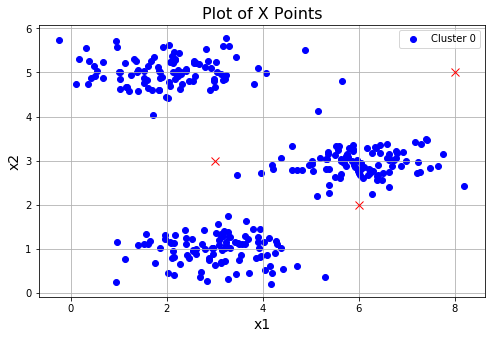

In [7]:
plot_data(X, [init_centroids])

In [8]:
def run_kmeans(X, centroids, max_iters):
    K = len(centroids)  # 中心点总数
    
    centroids_all = []
    centroids_all.append(centroids)
    centroid_i = centroids
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroid_i)
        centroid_i = compute_centroids(X, idx)
        centroids_all.append(centroid_i)
    
    return idx, centroids_all

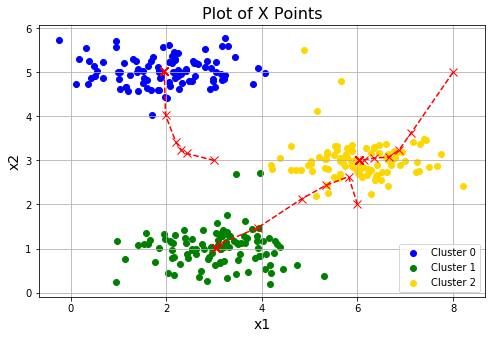

In [9]:
idx, centroids_all = run_kmeans(X, init_centroids, 20)
plot_data(X, centroids_all, idx)

## 1.3 Random initialization
在实践中，对簇中心点进行初始化的一个好的策略就是从训练集中选择随机的例子。

In [10]:
def init_centroids(X, K):
    """
    随机初始化
    """
    m, n = X.shape
    idx = np.random.choice(m, K)
    centroids = X[idx]
    return centroids

进行三次随机初始化，看下各自的效果。会发现有些效果并不理想，这是正常的，落入了局部最优。

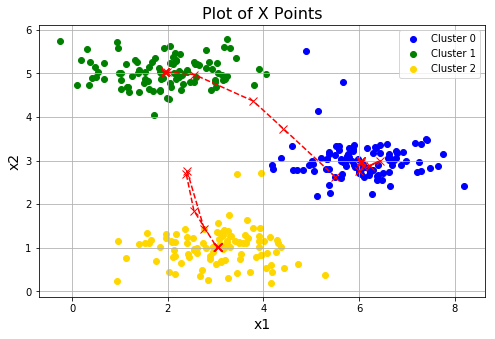

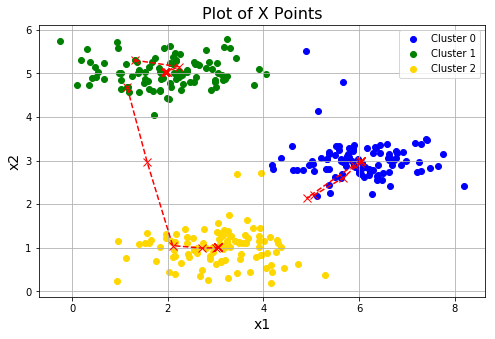

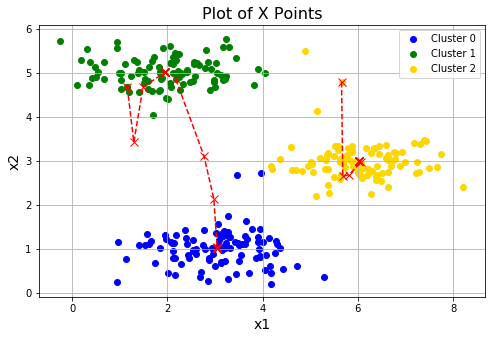

In [11]:
for i in range(3):
    centroids = init_centroids(X, 3)
    idx, centroids_all = run_kmeans(X, centroids, 10)
    plot_data(X, centroids_all, idx)

上面运行了三次随机初始化，可以看到不同的随机化，效果是不一样的。

## 1.4 Image compression with K-means
这部分你将用Kmeans来进行图片压缩。在一个简单的24位颜色表示图像。每个像素被表示为三个8位无符号整数(从0到255)，指定了红、绿和蓝色的强度值。这种编码通常被称为RGB编码。我们的图像包含数千种颜色，在这一部分的练习中，你将把颜色的数量减少到16种颜色。

这可以有效地压缩照片。具体地说，您只需要存储16个选中颜色的RGB值，而对于图中的每个像素，现在只需要将该颜色的索引存储在该位置(只需要4 bits就能表示16种可能性)。

接下来我们要用K-means算法选16种颜色，用于图片压缩。你将把原始图片的每个像素看作一个数据样本，然后利用K-means算法去找分组最好的16种颜色。

### 1.4.1 K-means on pixels

(128, 128, 3)


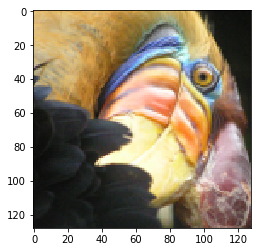

In [12]:
from skimage import io

A = io.imread('ex7/bird_small.png')
print(A.shape)
plt.imshow(A)
A = A / 255  # 除以255，使所有值都在0 - 1范围内

In [13]:
# 将图像重塑为(N,3)个矩阵，其中N = 像素数
# 每一行将包含红、绿、蓝像素值
# 这给出了我们的数据集矩阵X，我们将使用K-Means

X = A.reshape(-1, 3)
K = 16
centroids = init_centroids(X, K)
idx, centroids_all = run_kmeans(X, centroids, 10)

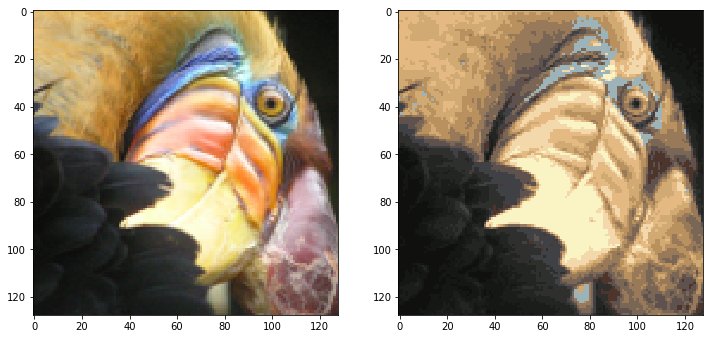

In [14]:
img = np.zeros(X.shape)
centroids = centroids_all[-1]
for i in range(len(centroids)):
    img[idx == i] = centroids[i]
    
img = img.reshape((128, 128, 3))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(A)
axes[1].imshow(img)

# 2、Principal Component Analysis
这部分，你将运用PCA来实现降维。您将首先通过一个2D数据集进行实验，以获得关于PCA如何工作的直观感受，然后在一个更大的图像数据集上使用它。

## 2.1 Example Dataset
为了帮助您理解PCA是如何工作的，您将首先从一个二维数据集开始，该数据集有一个大的变化方向和一个较小的变化方向。

在这部分练习中，您将看到使用PCA将数据从2D减少到1D时会发生什么。

(50, 2)


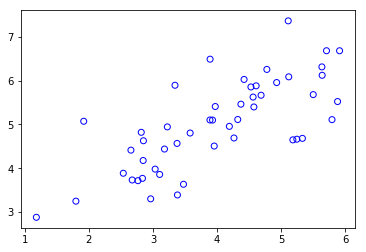

In [15]:
mat = loadmat('ex7/ex7data1.mat')
X = mat['X']
print(X.shape)
plt.scatter(X[:,0], X[:, 1], facecolors='none', edgecolors='b')

## 2.2 Implementing PCA
PCA由两部分组成：

* 计算数据的方差矩阵
* 用SVD计算特征向量$(U_1,U_2,...,U_n)$ 

在PCA之前，记得标准化数据。

然后计算方差矩阵，如果你的每条样本数据是以行的形式表示，那么计算公式如下：

$$\Sigma = \frac{1}{m}X^TX $$

接着就可以用SVD计算主成分

$$ [U, S, V] = svd(Sigma) $$

U包含了主成分，每一列就是我们数据要映射的向量，S为对角矩阵，为奇异值。

In [16]:
def feature_normalize(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0, ddof=1)
    X_norm = (X - means) / stds
    
    return X_norm, means, stds

由于我们的协方差矩阵为X.T@X, X中每行为一条数据，我们是想要对列(特征)做压缩。

这里由于是对协方差矩阵做SVD(), 所以得到的入口基其实为 V‘，出口基为V，可以打印出各自的shape来判断。

故我们这里是对 数据集的列 做压缩。

In [17]:
def pca(X):
    sigma = (X.T @ X) / len(X)
    U, S, V = np.linalg.svd(sigma)
    
    return U, S, V

In [18]:
X_norm, means, stds = feature_normalize(X)
U, S, V = pca(X_norm)
print(U[:, 0])

[-0.70710678 -0.70710678]


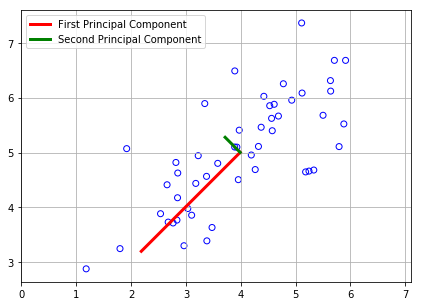

In [19]:
plt.figure(figsize=(7, 5))

plt.scatter(X[:,0], X[:,1], facecolor='none', edgecolors='b')

plt.plot([means[0], means[0] + 1.5*S[0]*U[0,0]],
         [means[1], means[1] + 1.5*S[0]*U[0,1]],
        c='r', linewidth=3, label='First Principal Component')
plt.plot([means[0], means[0] + 1.5*S[1]*U[1,0]],
         [means[1], means[1] + 1.5*S[1]*U[1,1]],
        c='g', linewidth=3, label='Second Principal Component')

plt.grid()
# 改变x或y轴的极限，使x和y的增量相等，长度相同
# 不然看着不垂直，不舒服
plt.axis('equal')
plt.legend()

## 2.3 Dimensionality Reduction with PCA
### 2.3.1 Projecting the data onto the principal components

In [20]:
def project_data(X, U, K):
    Z = X @ U[:,:K]
    
    return Z

In [21]:
Z = project_data(X_norm, U, 1)
Z[0]

array([1.48127391])

### 2.3.2 Reconstructing an approximation of the data
重建数据

In [22]:
def recover_data(Z, U, K):
    X_rec = Z @ U[:,:K].T
    
    return X_rec

In [23]:
X_rec = recover_data(Z, U, 1)
X_rec[0]

array([-1.04741883, -1.04741883])

### 2.3.3 Visualizing the projections

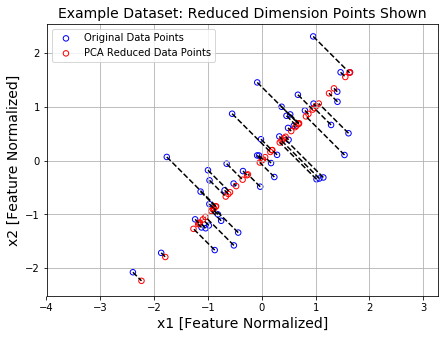

In [24]:
plt.figure(figsize=(7,5))
plt.axis('equal')
plot = plt.scatter(X_norm[:,0], X_norm[:,1], s=30, facecolors='none', 
                   edgecolors='b',label='Original Data Points')
plot = plt.scatter(X_rec[:,0], X_rec[:,1], s=30, facecolors='none', 
                   edgecolors='r',label='PCA Reduced Data Points')

plt.title("Example Dataset: Reduced Dimension Points Shown",fontsize=14)
plt.xlabel('x1 [Feature Normalized]',fontsize=14)
plt.ylabel('x2 [Feature Normalized]',fontsize=14)
plt.grid(True)

for x in range(X_norm.shape[0]):
    plt.plot([X_norm[x,0],X_rec[x,0]],[X_norm[x,1],X_rec[x,1]],'k--')
    # 输入第一项全是X坐标，第二项都是Y坐标
plt.legend()

## 2.4 Face Image Dataset
在这部分练习中，您将人脸图像上运行PCA，看看如何在实践中使用它来减少维度。

In [25]:
mat = loadmat('ex7/ex7faces.mat')
X = mat['X']
print(X.shape)

(5000, 1024)


In [26]:
def display_data(X, row, col):
    fig, axs = plt.subplots(row, col, figsize=(8,8))
    
    for r in range(row):
        for c in range(col):
            axs[r][c].imshow(X[r*col + c].reshape(32,32).T, cmap='Greys_r')
            axs[r][c].set_xticks([])
            axs[r][c].set_yticks([])

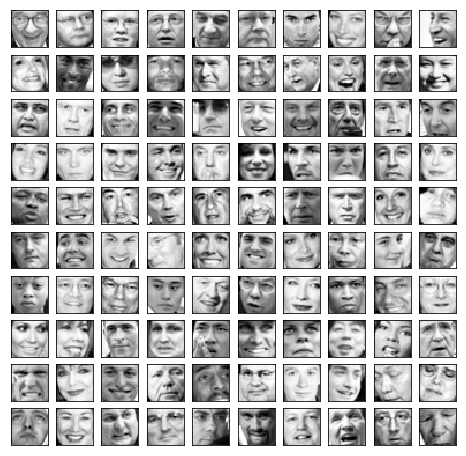

In [27]:
display_data(X, 10, 10)

### 2.4.1 PCA on Faces

In [28]:
X_norm, means, stds = feature_normalize(X)

U, S, V = pca(X_norm)

In [29]:
U.shape, S.shape

((1024, 1024), (1024,))

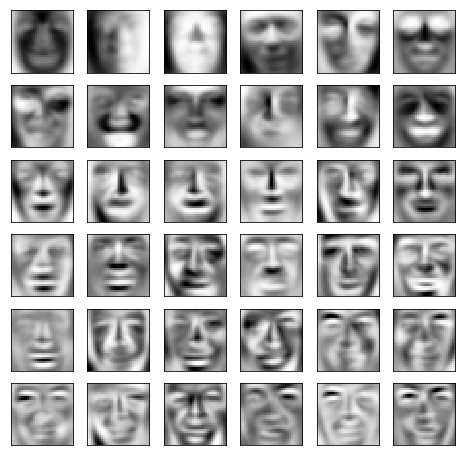

In [30]:
display_data(U[:,:36].T, 6, 6)

### 2.4.2 Dimensionality Reduction

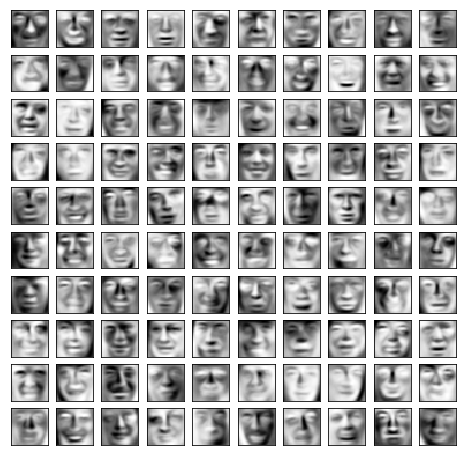

In [31]:
z = project_data(X_norm, U, K=36)
X_rec = recover_data(z, U, K=36)
display_data(X_rec, 10, 10)